In [1]:
# Install SHAP for model explainability
!pip install shap --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score
import shap


In [3]:
from google.colab import files

# Upload the small dataset: bank-additional.csv (≈4k rows)
uploaded = files.upload()

# Load dataset
df = pd.read_csv("bank.csv", sep=";")
df.head()


Saving bank.csv to bank.csv


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB

Target counts:
 y
no     4000
yes     521
Name: count, dtype: int64


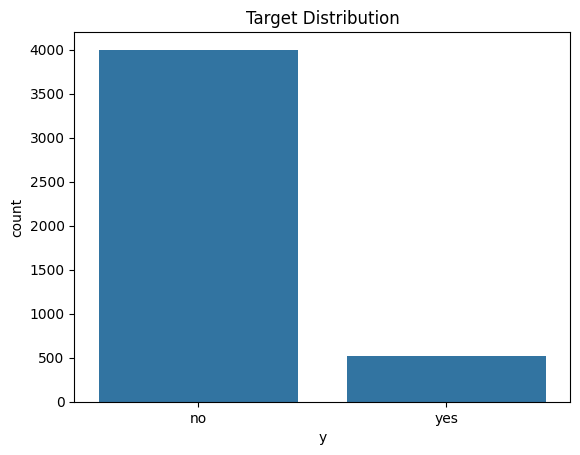

In [4]:
# Dataset info
df.info()

# Target distribution
print("\nTarget counts:\n", df['y'].value_counts())

sns.countplot(x='y', data=df)
plt.title("Target Distribution")
plt.show()


In [5]:
# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [6]:
# Features and target
X = df.drop('y', axis=1)
y = df['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Logistic Regression (needs scaled data)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Random Forest (trees don’t need scaling, so use unscaled data)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       801
           1       0.47      0.18      0.26       104

    accuracy                           0.88       905
   macro avg       0.69      0.58      0.60       905
weighted avg       0.85      0.88      0.86       905

Confusion Matrix:
 [[780  21]
 [ 85  19]]
F1-Score: 0.2638888888888889

Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       801
           1       0.54      0.28      0.37       104

    accuracy                           0.89       905
   macro avg       0.72      0.62      0.65       905
weighted avg       0.87      0.89      0.87       905

Confusion Matrix:
 [[776  25]
 [ 75  29]]
F1-Score: 0.3670886075949367


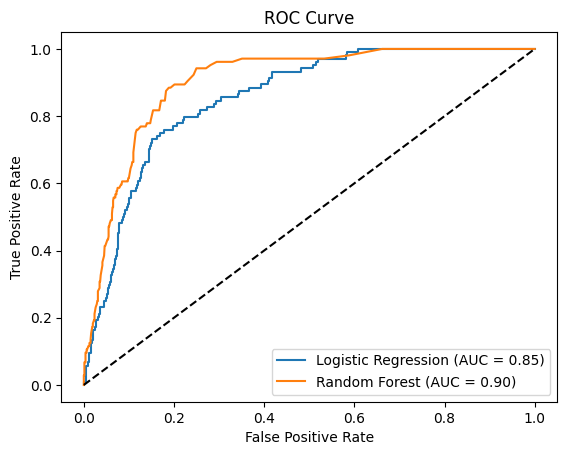

In [8]:
# Evaluate Logistic Regression
y_pred_log = log_reg.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("F1-Score:", f1_score(y_test, y_pred_log))

# Evaluate Random Forest
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))

# ROC Curve for both models
y_prob_log = log_reg.predict_proba(X_test_scaled)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc(fpr_log,tpr_log):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf,tpr_rf):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


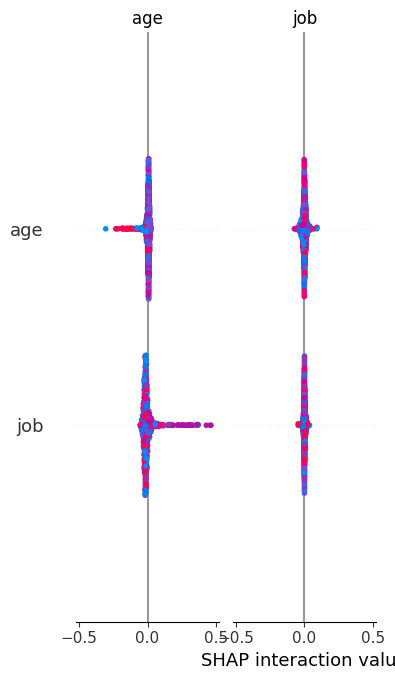

In [15]:
# SHAP for Random Forest (works with unscaled data)
explainer = shap.TreeExplainer(rf)
# Convert X_test to numpy array
X_test_np = X_test.values
shap_values = explainer.shap_values(X_test_np)

# Summary plot for "yes" class (1)
shap.summary_plot(shap_values, X_test_np, feature_names=X.columns)

In [13]:
print("Shape of shap_values:", len(shap_values), shap_values[0].shape, shap_values[1].shape)
print("Sample indices:", sample_idx)

Shape of shap_values: 905 (16, 2) (16, 2)
Sample indices: [266 181 818 663  47]
